<a href="https://colab.research.google.com/github/Abinaya120706/sms-spam-detection/blob/main/SMS_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install & imports
# Run this cell first. If Colab asks to restart runtime after install, restart and run cells again from 1.

# install (quiet)
!pip install -q scikit-learn nltk joblib textblob emoji

# standard imports
import os, re
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# nltk setup
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

print("Cell 1 complete — libraries installed and imported.")

Cell 1 complete — libraries installed and imported.


In [ ]:
# Cell 2: Load public SMS dataset automatically
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'], encoding='latin-1')
print("Loaded dataset shape:", df.shape)
print(df['label'].value_counts())
df.head(5)

Loaded dataset shape: (5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Cell 3: Rename labels for clarity
df['label'] = df['label'].replace({'ham': 'normal'})
print("Labels after rename:")
print(df['label'].value_counts())

Labels after rename:
label
normal    4825
spam       747
Name: count, dtype: int64


In [ ]:
# Cell 4: Preprocess function and apply
STOPWORDS = set(stopwords.words('english'))
LEM = WordNetLemmatizer()

url_re = re.compile(r'https?://\S+|www\.\S+')
email_re = re.compile(r'\S+@\S+')
phone_re = re.compile(r'\+?\d[\d\-\s]{6,}\d')
non_alphanum = re.compile(r'[^0-9a-zA-Z\s]')

def clean_text(text, remove_stopwords=True, lemmatize=True):
    if not isinstance(text, str):
        text = str(text)
    text = url_re.sub(' ', text)
    text = email_re.sub(' ', text)
    text = phone_re.sub(' ', text)
    text = text.lower()
    text = non_alphanum.sub(' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]
    if lemmatize:
        tokens = [LEM.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# create cleaned column
df['clean_message'] = df['message'].apply(clean_text)
print("Sample original -> cleaned:")
for i in range(3):
    print("ORIG:", df.loc[i,'message'])
    print("CLEAN:", df.loc[i,'clean_message'])
    print("---")

Sample original -> cleaned:
ORIG: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
CLEAN: go jurong point crazy available bugis n great world la e buffet cine got amore wat
---
ORIG: Ok lar... Joking wif u oni...
CLEAN: ok lar joking wif u oni
---
ORIG: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
CLEAN: free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry question std txt rate c apply over18
---


In [ ]:
# Cell 5: Train/test split (stratified)
X = df['clean_message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
print("Train size:", len(X_train), "Test size:", len(X_test))
print("Train label counts:\n", y_train.value_counts())

Train size: 4457 Test size: 1115
Train label counts:
 label
normal    3859
spam       598
Name: count, dtype: int64


In [ ]:
# Cell 6: Train Multinomial Naive Bayes baseline
pipe_nb = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2), min_df=2),
    MultinomialNB(alpha=0.5)
)
pipe_nb.fit(X_train, y_train)
y_pred_nb = pipe_nb.predict(X_test)

print("Naive Bayes results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision (spam):", precision_score(y_test, y_pred_nb, pos_label='spam'))
print("Recall (spam):", recall_score(y_test, y_pred_nb, pos_label='spam'))
print("F1 (spam):", f1_score(y_test, y_pred_nb, pos_label='spam'))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes results:
Accuracy: 0.9757847533632287
Precision (spam): 0.9919354838709677
Recall (spam): 0.825503355704698
F1 (spam): 0.9010989010989011

Confusion matrix:
 [[965   1]
 [ 26 123]]


In [ ]:
# Cell 7: Train Logistic Regression (useful to get coefficients / feature importance)
pipe_lr = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2), min_df=2),
    LogisticRegression(max_iter=500, solver='liblinear')
)
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

print("Logistic Regression F1 (spam):", f1_score(y_test, y_pred_lr, pos_label='spam'))

Logistic Regression F1 (spam): 0.8880597014925373


In [ ]:
# Cell 8: Keyword importance (handles LR and NB)
def get_vectorizer_and_clf(pipe):
    # find vectorizer and classifier from pipeline named_steps
    vec = None
    clf = None
    for step in pipe.named_steps.values():
        if isinstance(step, TfidfVectorizer):
            vec = step
        # classifier could be last; accept known classes
    # fallback: infer by type
    for name, step in pipe.named_steps.items():
        if name not in ('tfidfvectorizer',) and not isinstance(step, TfidfVectorizer):
            clf = step
    return vec, clf

# choose pipe for explainability: pipe_lr preferred (has coef_)
pipe_for_explain = pipe_lr  # use logistic regression pipeline (if you want NB, switch to pipe_nb)

vec, clf = get_vectorizer_and_clf(pipe_for_explain)
feature_names = np.array(vec.get_feature_names_out())

print("Model type used for explainability:", type(clf).__name__)

if hasattr(clf, 'coef_'):
    coefs = clf.coef_[0]
    top_spam_idx = np.argsort(coefs)[-20:][::-1]
    top_normal_idx = np.argsort(coefs)[:20]

    print("\nTop words indicating SPAM:")
    for w, s in zip(feature_names[top_spam_idx], coefs[top_spam_idx]):
        print(f"{w:20s} -> {s:.3f}")

    print("\nTop words indicating NORMAL:")
    for w, s in zip(feature_names[top_normal_idx], coefs[top_normal_idx]):
        print(f"{w:20s} -> {s:.3f}")

elif hasattr(clf, 'feature_log_prob_'):
    # MultinomialNB: feature_log_prob_ shape = (n_classes, n_features)
    # classes_ gives order; compute difference spam - normal
    classes = list(clf.classes_)
    probs = clf.feature_log_prob_
    # ensure we get index of spam and normal
    try:
        spam_idx = classes.index('spam')
        normal_idx = classes.index('normal')
        diff = probs[spam_idx] - probs[normal_idx]
        top_spam_idx = np.argsort(diff)[-20:][::-1]
        top_normal_idx = np.argsort(diff)[:20]

        print("\nTop words indicating SPAM (from NB):")
        for w, s in zip(feature_names[top_spam_idx], diff[top_spam_idx]):
            print(f"{w:20s} -> {s:.3f}")

        print("\nTop words indicating NORMAL (from NB):")
        for w, s in zip(feature_names[top_normal_idx], diff[top_normal_idx]):
            print(f"{w:20s} -> {s:.3f}")
    except ValueError:
        print("Unexpected class labels in NB:", classes)
else:
    print("Model does not expose coefficients or feature_log_prob_.")

Model type used for explainability: LogisticRegression

Top words indicating SPAM:
txt                  -> 4.442
mobile               -> 3.631
claim                -> 3.455
free                 -> 3.362
stop                 -> 3.206
reply                -> 3.139
service              -> 2.997
call                 -> 2.992
prize                -> 2.632
uk                   -> 2.448
tone                 -> 2.444
text                 -> 2.427
150p                 -> 2.357
win                  -> 2.269
50                   -> 2.220
cash                 -> 2.197
urgent               -> 2.041
new                  -> 2.019
18                   -> 1.977
ringtone             -> 1.875

Top words indicating NORMAL:
ok                   -> -1.885
home                 -> -1.463
sorry                -> -1.459
da                   -> -1.455
gt                   -> -1.427
lt                   -> -1.383
later                -> -1.374
got                  -> -1.351
lt gt                -> -1.207
good    

In [ ]:
# Cell 9: Sentiment & emoji analysis
from textblob import TextBlob
import emoji

def analyze_sentiment(msg):
    blob = TextBlob(msg)
    polarity = blob.sentiment.polarity
    if polarity > 0.2:
        return "positive"
    elif polarity < -0.2:
        return "negative"
    else:
        return "neutral"

def count_emojis(msg):
    # count visible emojis
    return sum(1 for ch in msg if ch in emoji.EMOJI_DATA)

# Test a few sample messages
samples = [
    "You have WON a free vacation 😍🏖️ Click the link now!",
    "Good morning! See you in class :)",
    "URGENT! Your account will be closed. Click here."
]

print("Sample sentiment & emoji analysis + model prediction:")
# use the saved NB or LR pipeline for prediction; prefer pipe_nb for demo
use_pipe = pipe_nb
for s in samples:
    pred = use_pipe.predict([s.lower()])[0]
    senti = analyze_sentiment(s)
    emo = count_emojis(s)
    print(f"\nMessage: {s}")
    print("-> Prediction:", pred, "| Sentiment:", senti, "| Emojis:", emo)

Sample sentiment & emoji analysis + model prediction:

Message: You have WON a free vacation 😍🏖️ Click the link now!
-> Prediction: spam | Sentiment: positive | Emojis: 2

Message: Good morning! See you in class :)
-> Prediction: normal | Sentiment: positive | Emojis: 0

Message: URGENT! Your account will be closed. Click here.
-> Prediction: normal | Sentiment: neutral | Emojis: 0


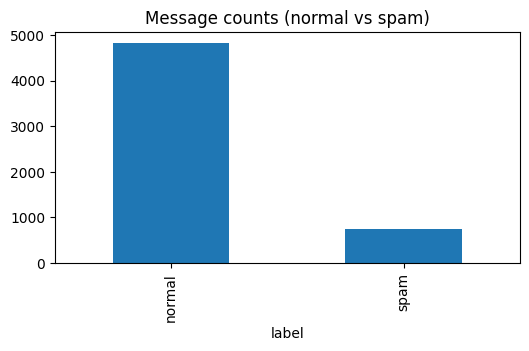

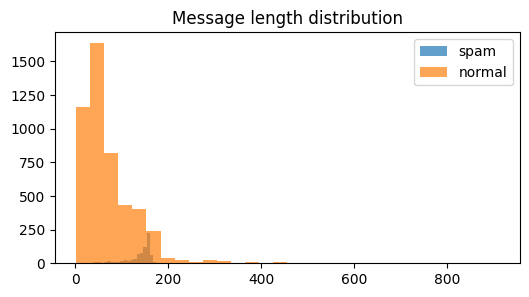

Saved Naive Bayes pipeline to: /content/sms_spam_pipeline.joblib


In [ ]:
# Cell 10: Visuals & save pipeline
import matplotlib.pyplot as plt

# Plot counts
plt.figure(figsize=(6,3))
df['label'].value_counts().plot(kind='bar', title='Message counts (normal vs spam)')
plt.show()

# Message length distribution
df['msg_len'] = df['message'].astype(str).apply(len)
plt.figure(figsize=(6,3))
plt.hist(df[df['label']=='spam']['msg_len'], bins=30, alpha=0.7, label='spam')
plt.hist(df[df['label']=='normal']['msg_len'], bins=30, alpha=0.7, label='normal')
plt.legend()
plt.title('Message length distribution')
plt.show()

# Save the preferred pipeline to disk (Naive Bayes baseline)
model_path = "/content/sms_spam_pipeline.joblib"
joblib.dump(pipe_nb, model_path)
print("Saved Naive Bayes pipeline to:", model_path)

In [ ]:
# Cell 11: Light text cleaning to keep important spam words
def clean_text_light(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_message'] = df['message'].apply(clean_text_light)

print("✅ Recreated clean text (light cleaning):")
print(df[['message','clean_message']].head(3))

✅ Recreated clean text (light cleaning):
                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   

                                       clean_message  
0  go until jurong point crazy available only in ...  
1                            ok lar joking wif u oni  
2  free entry in 2 a wkly comp to win fa cup fina...  


In [ ]:
# Cell 12: Retrain with Logistic Regression (balanced)
X = df['clean_message']
y = df['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

pipe_lr_fixed = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95),
    LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced')
)

pipe_lr_fixed.fit(X_train, y_train)
y_pred_fixed = pipe_lr_fixed.predict(X_test)

print("✅ New Logistic Regression model trained.")
print("Accuracy:", accuracy_score(y_test, y_pred_fixed))
print("Precision (spam):", precision_score(y_test, y_pred_fixed, pos_label='spam'))
print("Recall (spam):", recall_score(y_test, y_pred_fixed, pos_label='spam'))
print("F1 (spam):", f1_score(y_test, y_pred_fixed, pos_label='spam'))

joblib.dump(pipe_lr_fixed, "/content/sms_spam_pipeline.joblib")
print("💾 Saved fixed pipeline.")

✅ New Logistic Regression model trained.
Accuracy: 0.9829596412556054
Precision (spam): 0.9391891891891891
Recall (spam): 0.9328859060402684
F1 (spam): 0.936026936026936
💾 Saved fixed pipeline.


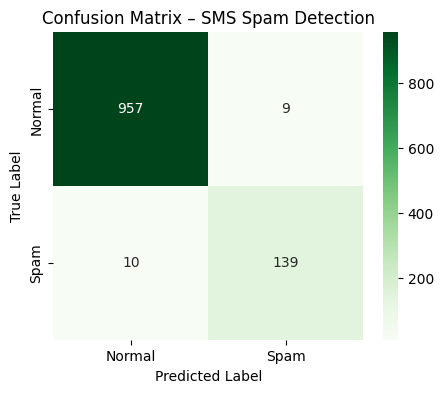

Classification Report:

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       966
        Spam       0.94      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [ ]:
# Cell 13: Confusion Matrix Heatmap + Classification Report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict on test data
y_pred = pipe_lr_fixed.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['normal', 'spam'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Spam'],
            yticklabels=['Normal', 'Spam'])
plt.title("Confusion Matrix – SMS Spam Detection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print detailed report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Spam']))

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


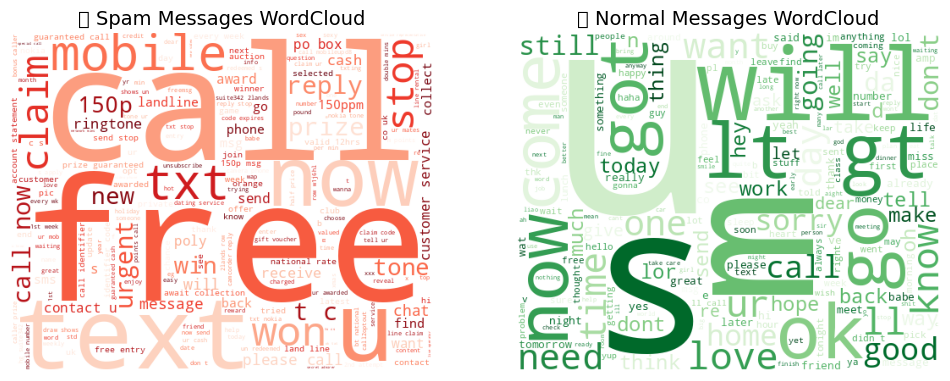

In [ ]:
# Cell 14: WordCloud for Normal and Spam messages
from wordcloud import WordCloud

# Separate the text by label
spam_texts = " ".join(df[df['label'] == 'spam']['clean_message'])
normal_texts = " ".join(df[df['label'] == 'normal']['clean_message'])

# Create WordClouds
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(WordCloud(width=500, height=400, background_color='white',
                     colormap='Reds').generate(spam_texts))
plt.title("🚨 Spam Messages WordCloud", fontsize=14)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=500, height=400, background_color='white',
                     colormap='Greens').generate(normal_texts))
plt.title("✅ Normal Messages WordCloud", fontsize=14)
plt.axis("off")

plt.show()

In [ ]:


# Cell 15: Interactive chat-style predictor
import joblib
pipe = joblib.load("/content/sms_spam_pipeline.joblib")  # NB pipeline saved above

def predict_sms(message):
    # returns label and probability (if available)
    pred = pipe.predict([message])[0]
    prob = None
    clf = list(pipe.named_steps.values())[-1]
    if hasattr(clf, "predict_proba"):
        prob = clf.predict_proba(pipe.named_steps['tfidfvectorizer'].transform([message]))  # careful transform
        # get spam index if exists
        try:
            idx = list(clf.classes_).index('spam')
            prob = float(prob[0][idx])
        except Exception:
            prob = None
    return pred, prob

print("Type messages below. To stop, type 'exit' and press Enter.")
while True:
    try:
        msg = input("Enter SMS: ")
    except Exception:
        # If your mobile input doesn't support continuous input, break gracefully
        print("Input not supported in this environment; you can call predict_sms(message) manually.")
        break
    if not msg:
        continue
    if msg.strip().lower() == 'exit':
        print("Chat ended.")
        break
    label, prob = predict_sms(msg)
    if label == 'normal':
        print(f"Prediction: NORMAL ✅   (probability: {prob:.3f})" if prob is not None else "Prediction: NORMAL ✅")
    else:
        print(f"Prediction: 🚨 SPAM 🚨   (probability: {prob:.3f})" if prob is not None else "Prediction: 🚨 SPAM 🚨")

Type messages below. To stop, type 'exit' and press Enter.
Enter SMS: Hey Raji, did you submit the project file? ✅
Prediction: NORMAL ✅   (probability: 0.100)
Enter SMS: URGENT! Your bank account has been blocked. Click here to verify.
Prediction: 🚨 SPAM 🚨   (probability: 0.650)
Enter SMS: I reached home safely. See you tomorrow 😊 
Prediction: NORMAL ✅   (probability: 0.077)
Enter SMS: Your ATM card will be suspended. Call +91 8000 999 888 immediately!
Prediction: 🚨 SPAM 🚨   (probability: 0.667)
Enter SMS: Exit.
Prediction: NORMAL ✅   (probability: 0.192)
